# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import content_aware_encode, train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, visualize_lr
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
seed = 970988852
#seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 1e-4,
    "warmup_factor": 5,
    'scheduler': 'cycles_buildoff',
    "cycles": 100,
    "lr_end": 1e-6,
    "power": 0.6,
    #"freeze_from_steps": -1,
    'freeze_once': True,
    'freeze_layer_rate': 1e-4 * 0.05,
    'to_freeze_count': 152,
    "seed": seed,
    "num_epoch": 1000
}

# Show me your LR!

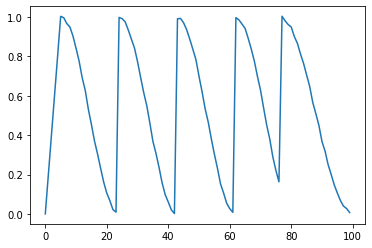

In [5]:
visualize_lr(config)

In [6]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained(Config.base_model_name)
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model(Config.base_model_name)
    print("Loaded empty model")
model = model.to(device)
print(f"{Config.base_model_name} loaded with {len(list(model.named_parameters()))} params...")
# set_pretrained_model_dropout(model.transformer.h, 0.0005)

Loaded empty model
EleutherAI/gpt-neo-125M loaded with 160 params...


# Test before training on a pretrained model!

In [7]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon-fishing guide for you.

Here are a few of the most popular tips on fishing, and why you should know them.

How to fish

Fishing is a fun activity, and you'll probably be interested in learning about it, but you may be surprised to learn that many of the things you can do to improve your luck, especially in the deep-water environment, is to fish. The fish you'll see in your life is a good example.

The first thing you'll notice is the fish's shape. This is the shape that you'll see


# Reviewing our dataset!

In [8]:
dataset = get_dataset(seed, tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
with open("data_train_sample2.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

  0%|          | 0/2 [00:00<?, ?it/s]

RP review!
scn>loremapt<msg>Lo "It's much easier to draw from a live model than from a photo, though."<p><msg>c "(Easier for you, maybe...)"<p><msg>c "I hope this doesn't take much longer, because my arms went numb a while ago."<d><scn>loremapt<msg>Lo "Yeah, I think you can relax for now. I'm nearly done with this one."<p><msg>c "Fight"<d><scn>loremapt<msg>m
----------
 enjoy that kind of work?"<p><msg>c "What do you think of Lorem?"<d><scn>emeraroom<msg>Em "I think he is ugly."<|endoftext|><p><msg>c "I'm not surprised. His stature is similar enough."<d><scn>testingroom<msg>An "True, true. Now shut up and let me concentrate."<p><msg>c "Does that approach ever work?"<d><scn>testingroom<msg>An "What are you talking about?"<|endoftext|><p><
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [9]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

train -> logging_steps: 910
[0] set freeze_part_layers: False (freezing 152 out of 160 layers.)


Step,Training Loss
100,2.931400
200,2.626300
300,2.410200
400,2.207000
500,2.085200
600,1.988900
700,1.951400
800,1.921100
900,1.898900
1000,1.889000


[23] set freeze_part_layers: True (freezing 152 out of 160 layers.)


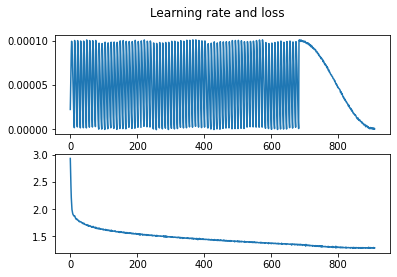

In [10]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [11]:
model.eval()
model.save_pretrained(saved_model_path)

# RP evaluation

In [12]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight",
    "Bite",
    "Attack",
    "Go to store"
]

for rp in test_rps:
    start_prompt = '<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."'
    print(f'{rp} -> {model_manager.say(start_prompt, rp)}')
    print(f'[sampled] {rp} -> {model_manager.say(start_prompt, rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> loremapt<msg>Ip "Hey [player_name]. I'm Lorem, right? I'm the owner of the vehicle."<p><msg>c "I was with Katsuharu today"<|endoftext|>
[sampled] Visit Lorem -> park2<msg>Ry "Hey [player_name]!"<|endoftext|>
----------
Meet with Lorem -> park2<msg>Mv "Hey [player_name]. I'm Lorem."<p><msg>c "I was with Remy today"<d><scn>park2<msg>Mv "Very nice"<|endoftext|>
[sampled] Meet with Lorem -> park2<msg>Mv "Hey [player_name]. I have a few more to show you."<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad "Hey [player_name]!"<|endoftext|>
[sampled] Visit Adine -> adineapt<msg>Ad "Hey [player_name]!"<|endoftext|>
----------
Fight -> park2<msg>m "Remy barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
[sampled] Fight -> park2<msg>m "Remy barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
-

In [13]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><sc>voln>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
    ('<p><msg>Nm "Ah, nice. I like it here."', "Can you swim?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "Very well."<p><msg>c "I was with Remy today"<d><scn>park2<msg>Ry "Very nice"<|endoftext|>
Reply [sampled]: park2<msg>Ry "Oh, I'm okay. My name is Remy."<p><msg>c "I was with Remy today"<d><scn>park2<msg>Ry "Very nice"<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he is good looking."<|endoftext|>
Reply [sampled]: park2<msg>Ad "I think he's good looking."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "I was with Katsuharu today"<|endoftext|>
Reply [sampled]: adineapt<msg>Ad "Hey, I didn't know you were into superheroes."<p><msg>c "How can you say that?"<d><scn>adineapt<msg>Ad "That's not what I said. I said it when I first heard it before. It's the first time you've ever been to a party in the place you're
----------
Prompt: What will we do here?
Reply: np1r<msg>Mv "I don't know. I don't like to have to talk to people."<p><msg>c "I see."<d><scn>np1r<msg>Mv "I don't 